In [1]:
import numpy as np
import nn
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from matplotlib.pyplot import plot
from nn import io, preprocess

In [2]:
pip install .

Processing /Users/ashvinravi/Desktop/bmi203/final-nn
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nn: filename=nn-0.1.0-py2.py3-none-any.whl size=9381 sha256=e726be728fb18e8910b6c81077f1b3614b0a4d224a57032b6531e31aecf7f787
  Stored in directory: /Users/ashvinravi/Library/Caches/pip/wheels/12/9f/2f/f02d5e0375e5ef0730f4545e1bd427d9cf5e6e4411d43e04bb
Successfully built nn
  Attempting uninstall: nn
    Found existing installation: nn 0.1.0
    Uninstalling nn-0.1.0:
      Successfully uninstalled nn-0.1.0
Note: you may need to restart the kernel to use updated packages.


**Ashvin Ravi \
March 18, 2024 \
BMI 203**

# Final Project NN 

## Part 1: Digits Autoencoder

Background
An autoencoder is a neural network that takes an input, encodes it into a lower-dimensional latent space through "encoding" layers, and then attempts to reconstruct the original input using "decoding" layers. Autoencoders are often used for dimensionality reduction.

Your task
You will train a 64x16x64 autoencoder on the digits dataset. All of the following work should be done in a Jupyter Notebook.

To-do
Load the digits dataset through sklearn using sklearn.datasets.load_digits().
Split the data into training and validation sets.
Generate an instance of your NeuralNetwork class with a 64x16x64 autoencoder architecture.
Train your autoencoder on the training data.
Plot your training and validation loss by epoch.
Quantify your average reconstruction error over the validation set.
Explain why you chose the hyperparameter values you did.

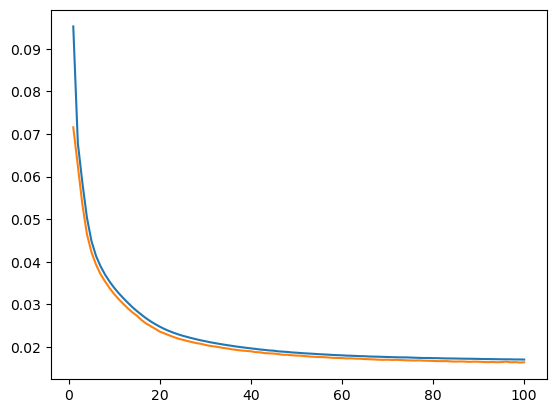

In [3]:
# Load the digits dataset
digits = load_digits()

# Normalize the data
scaler = MinMaxScaler()
X = scaler.fit_transform(digits.data)

# Split the data into training and testing sets
X_train, X_test, _, _ = train_test_split(X, X, test_size=0.2, random_state=42)

# Define and train the autoencoder
autoencoder = nn.NeuralNetwork(
    nn_arch=[{'input_dim': 64, 'output_dim': 16, 'activation': '_relu'},
             {'input_dim': 16, 'output_dim': 64, 'activation': '_relu'}],
    lr=0.01,
    seed=42,
    batch_size=10,
    epochs=100,
    loss_function='_mean_squared_error'
)

per_epoch_loss_train, per_epoch_loss_validation = autoencoder.fit(X_train, X_train, X_test, X_test)

loss_df = pd.DataFrame(per_epoch_loss_train)
loss_df = loss_df.rename({0: 'loss_train'}, axis='columns')
loss_df['loss_validation'] = per_epoch_loss_validation
loss_df['epochs'] = loss_df.index + 1

plot(loss_df['epochs'], loss_df['loss_train'])
plot(loss_df['epochs'], loss_df['loss_validation'])

In [3]:
reconstructed_images = autoencoder.predict(X_test)

reconstruction_errors = np.mean(np.square(X_test - reconstructed_images), axis=1)
average_reconstruction_error = np.mean(reconstruction_errors)

print("Average Reconstruction Error:", average_reconstruction_error)

Average Reconstruction Error: 0.012466131588395057


## Part 2: Train a Classifier for predicting DNA binding sites

In this part, I train a classifier for predicting DNA binding sites in yeast using positive sequences that distinguish transcription factors, and negative sequences, where it is known that there are no transcription factors within these negative sequences. First, I read in the positive and negative sequences using the io methods. 

In [5]:
positive = io.read_text_file('data/rap1-lieb-positives.txt')
negative = io.read_fasta_file('data/yeast-upstream-1k-negative.fa')
len(negative)
equal_length_negative = []

Next, because the negative sequences are much longer than the positive sequences (1000 vs. 17), I split the negative sequences into substrings of length 17, and filter out sequences that don't have length 17 (since this would be inconsistent with the autoencoder architecture, plus we have a good amount of negative training examples/labels already. I also flatten the numpy array once I get 17 sequences for each instance. 

In [6]:
for sequence in negative:
    n = 17
    equal_length = [sequence[i:i+n] for i in range(0, len(sequence), n)]
    equal_length_negative.append(equal_length)


negative_sequences = sum(equal_length_negative, [])
negative_sequences = pd.DataFrame(negative_sequences)
negative_sequences['negative'] = negative_sequences[0]
negative_sequences = negative_sequences.drop(columns=0)

negative_sequences = negative_sequences[negative_sequences.negative.apply(lambda x: len(str(x)) == 17)]

Because we have a huge class imbalance (~183,000 negative sequences vs. 137 positive sequences, we can balance our classes using the sample_seqs() method within preprocess. 

In [8]:
positive_sequences = pd.DataFrame(positive)
positive_sequences['positive'] = positive_sequences[0]
positive_sequences = positive_sequences.drop(columns=0)
positive_sequences['labels'] = "positive"

negative_sequences['labels'] = "negative"

positive_sequences = positive_sequences.rename(columns={'positive': 'seq', 'labels': 'labels'})
negative_sequences = negative_sequences.rename(columns={'negative': 'seq', 'labels': 'labels'})


In [9]:
# Concatenate and then randomly shuffle the positive and negative sequences 
sequences = pd.concat([positive_sequences, negative_sequences], ignore_index=True)
sequences = sequences.sample(frac = 1) # randomly permuted/reordered

sequences.index = range(0, 183434, 1)

In [10]:
# Randomly sample same proportion of sequences. 
seq = sequences['seq']
labels = sequences['labels']

# Convert labels to boolean
labels[labels == 'negative'] = False
labels[labels == 'positive'] = True
# print(labels.value_counts())

sampled_seqs, sampled_labels = preprocess.sample_seqs(list(seq), list(labels))

Finally, I one-hot encode my sampled sequence matrix for the autoencoder using the one_hot_encode_seqs() function constructed in preprocess.py. 

In [11]:
one_hot_encode_matrix = [preprocess.one_hot_encode_seqs(seq) for seq in sampled_seqs]
one_hot_encode_matrix = np.vstack(one_hot_encode_matrix)

### Autoencoder construction for neural network

Now, we will set up our autoencoder for classifying TF binding sites. Because we have sequences of length 17, and our one-hot encoded matrix adds 4 positions for each possible nucleotide, we have 68 possible features - one for each possible nucleotide. 

#### First, let's normalize the one-hot encoded matrix. 

In [12]:
# Normalize the data
scaler = MinMaxScaler()
X = scaler.fit_transform(one_hot_encode_matrix)

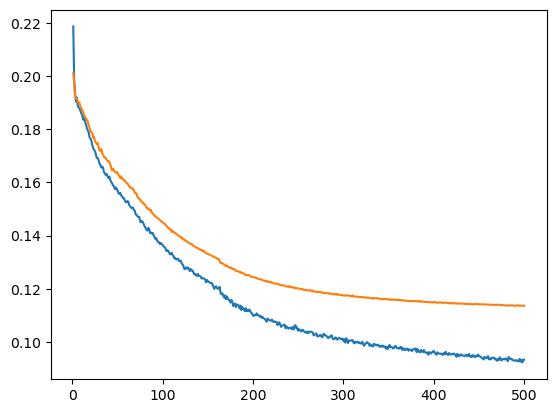

In [33]:
# Split the data into training and testing sets
X_train, X_test, _, _ = train_test_split(X, X, test_size=0.2, random_state=42)

# Define and train the autoencoder
autoencoder = nn.NeuralNetwork(
    nn_arch=[{'input_dim': 68, 'output_dim': 17, 'activation': '_sigmoid'},
             {'input_dim': 17, 'output_dim': 68, 'activation': '_relu'}],
    lr=0.02,
    seed=42,
    batch_size=128,
    epochs=500,
    loss_function='_mean_squared_error'
)

per_epoch_loss_train, per_epoch_loss_validation = autoencoder.fit(X_train, X_train, X_test, X_test)

loss_df = pd.DataFrame(per_epoch_loss_train)
loss_df = loss_df.rename({0: 'loss_train'}, axis='columns')
loss_df['loss_validation'] = per_epoch_loss_validation
loss_df['epochs'] = loss_df.index + 1

plot(loss_df['epochs'], loss_df['loss_train'])
plot(loss_df['epochs'], loss_df['loss_validation'])

In [34]:
reconstructed_images = autoencoder.predict(X_test)

reconstruction_errors = np.mean(np.square(X_test - reconstructed_images), axis=1)
average_reconstruction_error = np.mean(reconstruction_errors)

print("Average Reconstruction Error:", average_reconstruction_error)

Average Reconstruction Error: 0.11360467496247688
